In [185]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import BorderlineSMOTE

# Titanic DataSet

In [103]:
pdf = pd.read_csv('titanic.csv', header=0, sep=';')

In [104]:
pdf.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## EDA

In [4]:
pdf.shape

(1310, 14)

In [105]:
pdf['sex'] = pdf['sex'].map({'female': 1.0, 'male': 0.0})
pdf['embarked'] = pdf['embarked'].map({'C': 0.0, 'Q': 1.0, 'S': 2.0})
pdf['age'] = pdf['age'].apply(lambda val: str(val).replace(',', '.')).astype(float)
pdf['fare'] = pdf['fare'].apply(lambda val: str(val).replace(',', '.')).astype(float)

In [106]:
pdf.isna().sum()

pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1015
embarked        3
boat          824
body         1189
home.dest     565
dtype: int64

In [107]:
pdf = pdf.dropna(subset=['survived'])

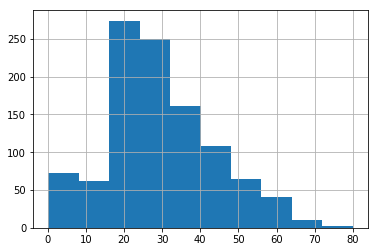

In [108]:
pdf['age'].hist()

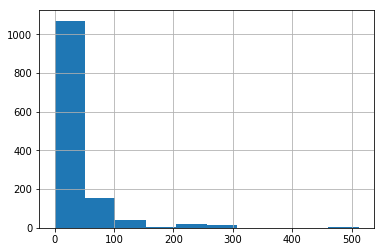

In [109]:
pdf['fare'].hist()

### Existing features analysis

In [9]:
pdf.groupby(['pclass'])['survived'].sum() / pdf.groupby(['pclass']).size()

pclass
1.0    0.619195
2.0    0.429603
3.0    0.255289
dtype: float64

In [10]:
pdf.groupby(['sex'])['survived'].sum() / pdf.groupby(['sex']).size()

sex
female    0.727468
male      0.190985
dtype: float64

In [11]:
pdf.groupby(['sex', 'pclass'])['survived'].sum() / pdf.groupby(['sex', 'pclass']).size()

sex     pclass
female  1.0       0.965278
        2.0       0.886792
        3.0       0.490741
male    1.0       0.340782
        2.0       0.146199
        3.0       0.152130
dtype: float64

In [12]:
pdf.groupby(['embarked'])['survived'].sum() / pdf.groupby(['embarked']).size()

embarked
C    0.555556
Q    0.357724
S    0.332604
dtype: float64

In [13]:
pdf.groupby(['parch'])['survived'].sum() / pdf.groupby(['parch']).size()

parch
0.0    0.335329
1.0    0.588235
2.0    0.504425
3.0    0.625000
4.0    0.166667
5.0    0.166667
6.0    0.000000
9.0    0.000000
dtype: float64

In [111]:
pdf['boated'] = (~pdf['boat'].isna()).astype(float)
pdf.groupby(['boated'])['survived'].sum() / pdf.groupby(['boated']).size()

boated
0.0    0.027947
1.0    0.981481
dtype: float64

In [16]:
pdf.groupby(['sex', 'pclass', 'boated'])['survived'].sum() / pdf.groupby(['sex', 'pclass', 'boated']).size()

sex     pclass  boated
female  1.0     0.0       0.166667
                1.0       1.000000
        2.0     0.0       0.400000
                1.0       1.000000
        3.0     0.0       0.099174
                1.0       0.989474
male    1.0     0.0       0.000000
                1.0       0.968254
        2.0     0.0       0.000000
                1.0       0.961538
        3.0     0.0       0.004819
                1.0       0.935897
dtype: float64

In [17]:
pdf.groupby(['sibsp'])['survived'].sum() / pdf.groupby(['sibsp']).size()

sibsp
0.0    0.346801
1.0    0.510972
2.0    0.452381
3.0    0.300000
4.0    0.136364
5.0    0.000000
8.0    0.000000
dtype: float64

## Modelling with TensorFlow

In [112]:
features = ['boated', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'fare']
pdf_clear = pdf[features + ['survived']]
X_train, X_test, y_train, y_test = train_test_split(pdf_clear[features], pdf_clear['survived'], test_size=0.5)

In [113]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)
y_train = pd.Series(y_train.values)
y_test = pd.Series(y_test.values)

In [81]:
def get_batch(X, y, batch_size=10):
    indices = np.random.choice(X.index, batch_size)
    return X.loc[indices], y.loc[indices]


def predict_logistic_regression_tf(X_train, y_train, X_test, n_iter=100, learning_rate=0.05, batch_size=50):
    x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    y = tf.placeholder(tf.float32, [None, 1])
    W = tf.Variable(tf.zeros([X_train.shape[1], 1]))
    b = tf.Variable(tf.zeros([1]))

    logit = tf.matmul(x, W) + b
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=y))

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    prediction = tf.nn.sigmoid(logit)

    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)

    for i in range(n_iter):
        batch_xs, batch_ys = get_batch(X_train, y_train, batch_size=batch_size)
        sess.run(train_step, feed_dict={x: batch_xs, y: np.array([batch_ys.values]).T})

    return sess.run(prediction, feed_dict={x: X_test})

We will try two different approaches of NaN-dealing:

### Filling NaNs with 0

In [115]:
y_pred = predict_logistic_regression_tf(X_train.fillna(0.0), y_train, X_test.fillna(0.0), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       416
         1.0       0.95      0.97      0.96       239

   micro avg       0.97      0.97      0.97       655
   macro avg       0.96      0.97      0.97       655
weighted avg       0.97      0.97      0.97       655

ROC-AUC score: 0.9878952767943353


### Filling NaNs with mean value

In [88]:
def fillna_mean(df):
    return df.fillna({col: df[col].mean() for col in df.columns})

In [116]:
y_pred = predict_logistic_regression_tf(fillna_mean(X_train), y_train, fillna_mean(X_test), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       416
         1.0       0.95      0.96      0.95       239

   micro avg       0.97      0.97      0.97       655
   macro avg       0.96      0.97      0.96       655
weighted avg       0.97      0.97      0.97       655

ROC-AUC score: 0.9886093900869005


## Modelling with Keras

In [77]:
def predict_logistic_regression_keras(X_train, y_train, X_test, n_iter=100, learning_rate=0.05, batch_size=50):
    model = Sequential()
    model.add(Dense(units=1, input_dim=X_train.shape[1], activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_iter)
    return model.predict(X_test)

### Filling NaNs with 0

In [119]:
y_pred = predict_logistic_regression_keras(X_train.fillna(0.0), y_train, X_test.fillna(0.0), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

Epoch 1/10
654/654 [==============================] - 1s 1ms/step - loss: 0.3966 - acc: 0.8807
Epoch 2/10
654/654 [==============================] - 0s 52us/step - loss: 0.2550 - acc: 0.9602
Epoch 3/10
654/654 [==============================] - 0s 58us/step - loss: 0.1968 - acc: 0.9664
Epoch 4/10
654/654 [==============================] - 0s 52us/step - loss: 0.1667 - acc: 0.9679
Epoch 5/10
654/654 [==============================] - 0s 53us/step - loss: 0.1486 - acc: 0.9709
Epoch 6/10
654/654 [==============================] - 0s 52us/step - loss: 0.1362 - acc: 0.9709
Epoch 7/10
654/654 [==============================] - 0s 62us/step - loss: 0.1277 - acc: 0.9709
Epoch 8/10
654/654 [==============================] - 0s 55us/step - loss: 0.1212 - acc: 0.9709
Epoch 9/10
654/654 [==============================] - 0s 54us/step - loss: 0.1162 - acc: 0.9709
Epoch 10/10
654/654 [==============================] - 0s 54us/step - loss: 0.1122 - acc: 0.9709
              precision    recall  f1-sc

### Filling NaNs with mean value

In [120]:
y_pred = predict_logistic_regression_keras(fillna_mean(X_train), y_train, fillna_mean(X_test), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

Epoch 1/10
654/654 [==============================] - 1s 1ms/step - loss: 0.6665 - acc: 0.6239
Epoch 2/10
654/654 [==============================] - 0s 55us/step - loss: 0.3424 - acc: 0.8884
Epoch 3/10
654/654 [==============================] - 0s 50us/step - loss: 0.2416 - acc: 0.9602
Epoch 4/10
654/654 [==============================] - 0s 50us/step - loss: 0.1937 - acc: 0.9694
Epoch 5/10
654/654 [==============================] - 0s 52us/step - loss: 0.1659 - acc: 0.9709
Epoch 6/10
654/654 [==============================] - 0s 56us/step - loss: 0.1482 - acc: 0.9709
Epoch 7/10
654/654 [==============================] - 0s 55us/step - loss: 0.1362 - acc: 0.9709
Epoch 8/10
654/654 [==============================] - 0s 53us/step - loss: 0.1275 - acc: 0.9709
Epoch 9/10
654/654 [==============================] - 0s 57us/step - loss: 0.1210 - acc: 0.9709
Epoch 10/10
654/654 [==============================] - 0s 52us/step - loss: 0.1159 - acc: 0.9709
              precision    recall  f1-sc

Keras model is a bit better, but still the results are almost the same

# Thyroid Disease DataSet

We have already done a full EDA of this dataset in HW3, so we will just be using preprocessed train and test sets from that notebook.

In [155]:
train = pd.read_csv('thyroid_train.csv')
test = pd.read_csv('thyroid_test.csv')

In [156]:
train.head()

,TSH,TT4,on_thyroxine,T4U,Class
0,-0.178313,-0.984492,0,1.176381,0
1,-0.165593,-0.070426,0,-0.662252,0
2,-0.093509,-0.896034,0,0.257065,0
3,-0.106229,0.047518,0,-0.554097,0
4,-0.166441,1.226959,0,0.202987,0


In [157]:
train.Class.value_counts()

0    2444
1     136
2      60
Name: Class, dtype: int64

In [158]:
test.Class.value_counts()

0    1037
1      58
2      37
Name: Class, dtype: int64

In [159]:
train.isna().sum()

TSH             0
TT4             0
on_thyroxine    0
T4U             0
Class           0
dtype: int64

In [128]:
test.isna().sum()

TSH             0
TT4             0
on_thyroxine    0
Class           0
dtype: int64

In [193]:
cols = ['TSH', 'TT4', 'on_thyroxine', 'T4U']
X_train = train[cols]
X_test = test[cols]
y_train = train['Class']
y_test = test['Class']

## Modelling with Tensorflow

In [178]:
def predict_logistic_regression_tf_multiclass(X_train, y_train, X_test, n_iter=100, learning_rate=0.05):
    x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    y = tf.placeholder(tf.float32, [None, 3])
    W = tf.Variable(tf.zeros([X_train.shape[1], 3]))
    b = tf.Variable(tf.zeros([3]))

    logit = tf.matmul(x, W) + b
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y))

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    prediction = tf.argmax(tf.nn.softmax(logit), 1)

    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).todense()
    for i in range(n_iter):
        sess.run(train_step, feed_dict={x: X_train, y: y_train})

    return sess.run(prediction, feed_dict={x: X_test})

In [194]:
y_pred = predict_logistic_regression_tf_multiclass(X_train, y_train, X_test, n_iter=500, learning_rate=4)
print(classification_report(y_test, y_pred))
print(recall_score(y_test, y_pred, average='macro', labels=[1, 2]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1037
           1       0.82      1.00      0.90        58
           2       0.82      0.97      0.89        37

   micro avg       0.98      0.98      0.98      1132
   macro avg       0.88      0.98      0.93      1132
weighted avg       0.98      0.98      0.98      1132

0.9864864864864865


Actually we even got a bit better result than in the original HW3 (0.969)

## Modelling with Keras

In [199]:
def predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=100, learning_rate=0.05):
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).todense()
    model = Sequential()
    model.add(Dense(units=3, input_dim=X_train.shape[1], activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_iter)
    return np.argmax(model.predict(X_test), axis=1)

In [208]:
y_pred = predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=50, learning_rate=2)
print(classification_report(y_test, y_pred))
print(recall_score(y_test, y_pred, average='macro', labels=[1, 2]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Epoch 1/50
7332/7332 [==============================] - 2s 226us/step - loss: 0.3080 - acc: 0.9303
Epoch 2/50
7332/7332 [==============================] - 0s 48us/step - loss: 0.1653 - acc: 0.9780
Epoch 3/50
7332/7332 [==============================] - 0s 49us/step - loss: 0.1405 - acc: 0.9793
Epoch 4/50
7332/7332 [==============================] - 0s 47us/step - loss: 0.1266 - acc: 0.9816
Epoch 5/50
7332/7332 [==============================] - 0s 45us/step - loss: 0.1183 - acc: 0.9824
Epoch 6/50
7332/7332 [==============================] - 0s 48us/step - loss: 0.1135 - acc: 0.9821
Epoch 7/50
7332/7332 [==============================] - 0s 47us/step - loss: 0.1095 - acc: 0.9840
Epoch 8/50
7332/7332 [==============================] - 0s 45us/step - loss: 0.1060 - acc: 0.9834
Epoch 9/50
7332/7332 [==============================] - 0s 49us/step - loss: 0.1035 - acc: 0.9853
Epoch 10/50
7332/7332 [==============================] - 0s 46us/step - loss: 0.1011 - acc: 0.9853
Epoch 11/50
7332/7